## Stage 2: Feature Engineering and Operational EDA

### Objective
The goal of this stage is to engineer robust features that capture the causal drivers of flight delays—specifically historical operational efficiency and environmental factors—while establishing a clear narrative for stakeholders. Key deliverables include:
1. Creating metrics like 'opera_historical_delay_rate' to quantify operator reliability.
2. Implementing imputation strategies that preserve information about missing data (e.g., sensor failures) rather than discarding it.
3. Visualizing delay patterns to identify high-risk segments (e.g., specific airlines or times of day) for operational intervention.

## 1. Configuration and Library Imports

In [73]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from datetime import datetime
import requests
from scipy.stats import ttest_ind

# Setting configurations
sns.set_style("whitegrid")
pd.set_option('display.max_columns', 100)
%matplotlib inline

##  2. Load Data from Previous Stage

In [55]:
# Load the cleaned data from Stage 1.
try:
    df = pd.read_csv('../data/interim/01_cleaned_target_data.csv', parse_dates=['scheduled_departure', 'actual_departure'])
    print(f"Data loaded from interim with {len(df)} rows.")
except FileNotFoundError:
    print("Error: Could not load data. Ensure '01_cleaned_target_data.csv' is in the '../data/interim/' path.")
    df = None

if df is None:
    # Stop execution if data is not loaded
    raise SystemExit("Data loading failed. Cannot proceed to Stage 2.")

Data loaded from interim with 68206 rows.


## 3. Feature Engineering: Historical and External Factors

#### 3.1 Historical Efficiency
Historical efficiency metrics (e.g., past delay rates for specific airlines or routes) serve as strong proxies for future performance, capturing systemic operational constraints inherent to each operator.

In [56]:
# Feature: Historical delay rate of the airline ('operating_airline')
df_temp = df[['operating_airline', 'destination_city_name', 'delay_15']].copy()
historical_delay = df_temp.groupby('operating_airline')['delay_15'].mean().reset_index()
historical_delay.rename(columns={'delay_15': 'opera_historical_delay_rate'}, inplace=True)
df = df.merge(historical_delay, on='operating_airline', how='left')

In [57]:
# Feature: Historical delay rate of the destination ('destination_city_name')
historical_dest_delay = df_temp.groupby('destination_city_name')['delay_15'].mean().reset_index()
historical_dest_delay.rename(columns={'delay_15': 'dest_historical_delay_rate'}, inplace=True)
df = df.merge(historical_dest_delay, on='destination_city_name', how='left')

#### 3.2 External Data Integration & Cleaning (Weather & Missing Data Handling)
- To capture environmental impacts, the dataset was enriched with historical weather data (Temperature, Pressure, Wind Speed) sourced via the Open-Meteo API.
- Instead of standard mean imputation or row deletion, a two-step approach was adopted to handle missing weather data (e.g., during sensor outages):
    1. A _is_missing indicator was created for each weather feature to explicitly model the absence of data as a potential risk signal.
    2. Missing values were filled with the median, providing resilience against outliers compared to the mean.

In [58]:
# --- 1. FETCH WEATHER DATA (Open-Meteo API) ---
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": -33.393,
    "longitude": -70.7858,
    "start_date": "2017-01-01",
    "end_date": "2017-12-31",
    "hourly": "temperature_2m,surface_pressure,wind_speed_10m",
    "timezone": "auto"
}

print("1. Fetching weather data from Open-Meteo...")
response = requests.get(url, params=params)
if response.status_code != 200:
    raise Exception(f"API Error: {response.status_code}")

data = response.json()
hourly_data = data['hourly']

# Create Weather DataFrame
df_weather = pd.DataFrame({
    'join_time': pd.to_datetime(hourly_data['time']),
    'temp': hourly_data['temperature_2m'],
    'pres': hourly_data['surface_pressure'],
    'wspd': hourly_data['wind_speed_10m']
})

# Remove timezone info to avoid conflicts with the flight dataframe
df_weather['join_time'] = df_weather['join_time'].dt.tz_localize(None)


1. Fetching weather data from Open-Meteo...


In [59]:
# --- 2. PREPARE FLIGHT DATAFRAME ---
# Ensure 'join_time' in flight data matches weather format (hourly floor)
df['join_time'] = pd.to_datetime(df['scheduled_departure']).dt.floor('h')

In [60]:
# --- 3. MERGE DATA ---
print("2. Merging flight and weather tables...")

# Drop temp/pres/wspd from df if they already exist to avoid duplicates (temp_x, temp_y)
cols_to_drop = [c for c in ['temp', 'pres', 'wspd'] if c in df.columns]
if cols_to_drop:
    df = df.drop(columns=cols_to_drop)

# Left join to keep all flight records
df = df.merge(df_weather, on='join_time', how='left')


2. Merging flight and weather tables...


In [61]:
# --- 4. IMPUTATION (ROBUST HANDLING) ---
print("3. Handling missing values...")
EXTERNAL_COLS = ['temp', 'wspd', 'pres']

for col in EXTERNAL_COLS:
    # A. Feature Engineering: Create Missingness Flag
    # This tells the model: "Data was missing here," preserving info about sensor failures.
    df[f'{col}_is_missing'] = df[col].isnull().astype(int)
    
    # B. Imputation: Fill with Median
    # Using median is more robust to outliers than the mean.
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

print(f"Done! Final dimensions: {df.shape}")
print("Integrated weather columns sample:", df[['temp', 'wspd', 'pres']].head(3))

3. Handling missing values...
Done! Final dimensions: (68206, 31)
Integrated weather columns sample:    temp  wspd   pres
0  22.2   2.8  959.4
1  20.9   5.5  960.3
2  18.2   8.2  958.7


## 4. Exploratory Data Analysis (EDA) 
The goal is understand where (Airline), when (Time), and under what conditions (Weather) the risk is highest.


In [64]:
# Create directory for figures if it doesn't exist
os.makedirs('../reports/figures', exist_ok=True)


#### 4.1 Delay Rate by Period of Day (Time of Day Congestion)

In [66]:
# Feature Engineering for Visualization: Create 'period_day'
def get_period(hour_scheduled):
    if 5 <= hour_scheduled <= 11: return 'morning'
    elif 12 <= hour_scheduled <= 18: return 'afternoon'
    else: return 'night'

# Apply logic only if column doesn't exist (avoid overwriting if logic changes)
if 'period_day' not in df.columns:
    df['period_day'] = df['hour_scheduled'].apply(get_period)



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



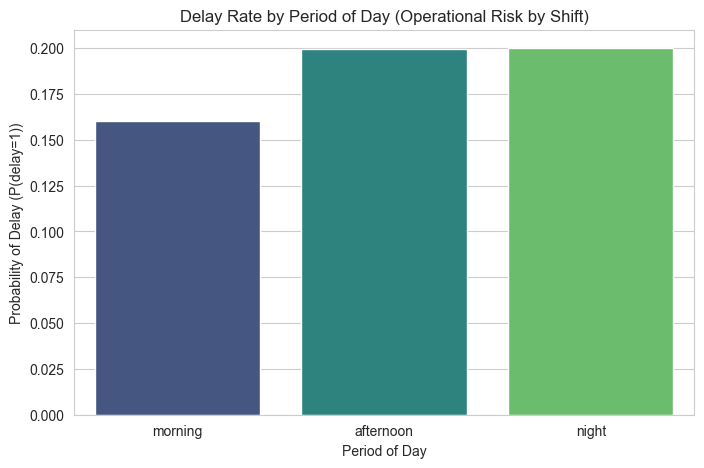

In [67]:
plt.figure(figsize=(8, 5))
sns.barplot(
    x='period_day', 
    y='delay_15', 
    data=df, 
    errorbar=None, 
    palette='viridis', 
    order=['morning', 'afternoon', 'night']
)
plt.title('Delay Rate by Period of Day (Operational Risk by Shift)')
plt.ylabel('Probability of Delay (P(delay=1))')
plt.xlabel('Period of Day')
plt.savefig('../reports/figures/delay_rate_by_period.png')
plt.show()


The Afternoon/Night shifts usually show higher risk due to accumulated operational strain (congestion).

#### 4.2 Delay Rate by Historical Operator Risk (validating 'operating_airline')


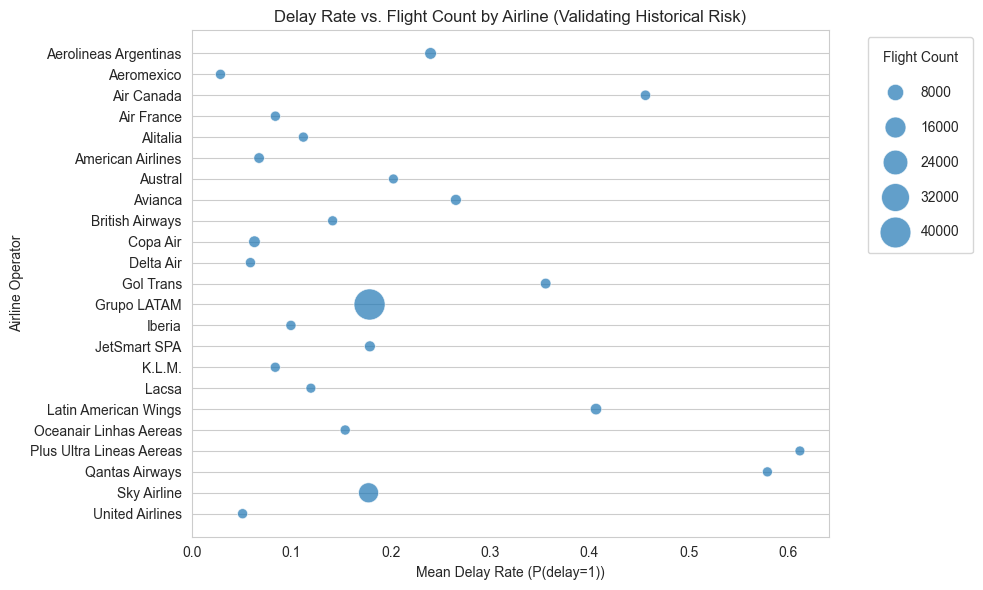

In [69]:
plt.figure(figsize=(10, 6))
# Using a scatter plot grouped by operator, sizing by count for clearer insight.
operator_risk_data = df.groupby('operating_airline')['delay_15'].agg(['mean', 'count']).reset_index()
sns.scatterplot(
    x='mean', 
    y='operating_airline', 
    data=operator_risk_data, 
    size='count', 
    sizes=(50, 500), 
    alpha=0.7,
    palette='plasma'
)
plt.title('Delay Rate vs. Flight Count by Airline (Validating Historical Risk)')
plt.ylabel('Airline Operator')
plt.xlabel('Mean Delay Rate (P(delay=1))')
plt.legend(title='Flight Count',bbox_to_anchor=(1.05, 1),loc='upper left',labelspacing=1.5,borderpad=1)
plt.grid(axis='x')
plt.tight_layout()
plt.savefig('../reports/figures/opera_historical_risk.png')
plt.show()

The visualization of delay rates by airline reveals distinct operational profiles. Major carriers like LATAM and Sky Airline (represented by the largest bubbles) maintain delay rates near the 18-20% average, effectively setting the baseline risk for the airport. In contrast, United Airlines and Aeromexico exhibit consistently low delay rates (<10%), serving as strong indicators for on-time performance. Conversely, operators like Qantas and Plus Ultra, despite lower flight volumes, show delay rates exceeding 50%, making them nearly deterministic predictors of delay. This high variance confirms that operating_airline is a critical predictive feature.

#### 4.3 Weather Impact Analysis
Determine if extreme weather conditions correlate with delays.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



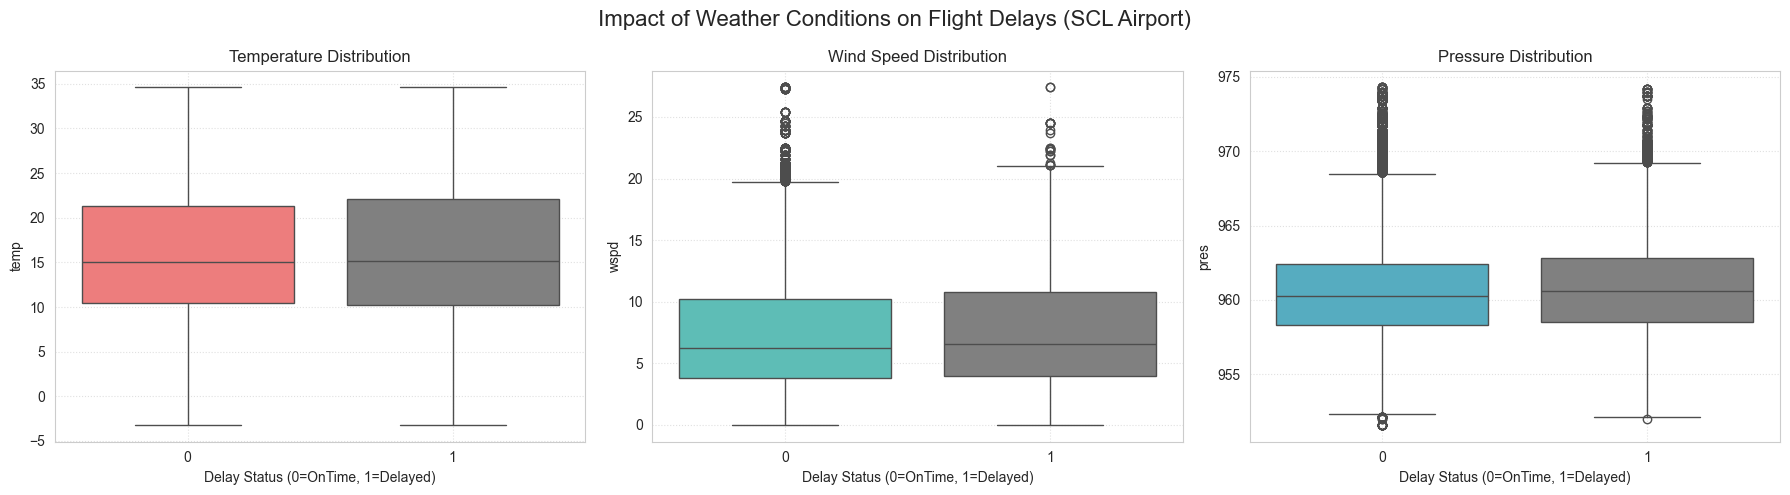

In [70]:
# Set up the matplotlib figure (3 subplots side by side)
f, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=False)

weather_features = ['temp', 'wspd', 'pres']
titles = ['Temperature Distribution', 'Wind Speed Distribution', 'Pressure Distribution']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for i, col in enumerate(weather_features):
    # Using Boxplots to see the shift in distribution between On-Time (0) vs Delayed (1)
    sns.boxplot(x='delay_15', y=col, data=df, ax=axes[i], palette=[colors[i], 'gray'])
    
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Delay Status (0=OnTime, 1=Delayed)')
    axes[i].grid(True, linestyle=':', alpha=0.6)

plt.suptitle('Impact of Weather Conditions on Flight Delays (SCL Airport)', fontsize=16)
plt.tight_layout()
plt.savefig('../reports/figures/weather_impact_analysis.png')
plt.show()


##### T-test for wather variables:

A T-Test was conducted for weather variables to statistically validate whether conditions (Wind Speed, Pressure, Temperature) differ significantly between delayed and on-time flights. This hypothesis-driven approach ensures that only environmentally relevant features are fed into the model, reducing noise.

In [74]:
print("--- Hypothesis Test (T-Test) for Weather Variables ---")
features_to_test = ['temp', 'wspd', 'pres']

for col in features_to_test:
    # Separate groups: Delayed (1) vs On-Time (0)
    group_delayed = df[df['delay_15'] == 1][col]
    group_ontime = df[df['delay_15'] == 0][col]
    
    # Run 2-tailed T-Test (assuming unequal variances -> Welch's t-test)
    stat, p_value = ttest_ind(group_delayed, group_ontime, equal_var=False)
    
    print(f"\nVariable: {col}")
    print(f"  - Mean (Delayed): {group_delayed.mean():.2f}")
    print(f"  - Mean (OnTime):  {group_ontime.mean():.2f}")
    print(f"  - P-value: {p_value:.5f}")
    
    if p_value < 0.05:
        print("  ✅ RESULT: Statistically Significant Difference (Useful feature).")
    else:
        print("  ❌ RESULT: No significant difference (Likely noise).")

--- Hypothesis Test (T-Test) for Weather Variables ---

Variable: temp
  - Mean (Delayed): 16.14
  - Mean (OnTime):  16.06
  - P-value: 0.29240
  ❌ RESULT: No significant difference (Likely noise).

Variable: wspd
  - Mean (Delayed): 7.78
  - Mean (OnTime):  7.35
  - P-value: 0.00000
  ✅ RESULT: Statistically Significant Difference (Useful feature).

Variable: pres
  - Mean (Delayed): 960.95
  - Mean (OnTime):  960.60
  - P-value: 0.00000
  ✅ RESULT: Statistically Significant Difference (Useful feature).


- Wind Speed (wspd): The T-Test confirms a statistically significant difference ($p < 0.001$). Delayed flights exhibit higher average wind speeds and a greater frequency of outliers in the upper range. This validates wind as a genuine environmental constraint. 

- Pressure (pres): While the p-value indicates significance ($p < 0.001$), the absolute difference in means is negligible (~0.35 hPa). This significance is likely driven by the large sample size rather than a practical operational impact. 

- Temperature (temp): There is no statistical evidence that temperature impacts delays at SCL ($p=0.29$). The distributions for on-time and delayed flights are visually identical. 


## 5. Feature Selection - Removing noisy features

Based on T-test analysis, the Temperature is statistical insignificant so will then be removed to reduce model complexity.

In [75]:
# List of features to drop based on T-Test results (insignificant p-value)
features_to_drop = ['temp', 'temp_is_missing']

print(f"Dropping irrelevant features: {features_to_drop}")
df = df.drop(columns=features_to_drop, errors='ignore')

# Final Verification
print(f"Updated dimensions: {df.shape}")
print("Remaining columns:", df.columns.tolist())

Dropping irrelevant features: ['temp', 'temp_is_missing']
Updated dimensions: (68206, 30)
Remaining columns: ['scheduled_departure', 'scheduled_flight_num', 'scheduled_origin', 'scheduled_destination', 'scheduled_airline', 'actual_departure', 'actual_flight_num', 'actual_origin', 'actual_destination', 'actual_airline', 'day_of_month', 'month', 'year', 'day_of_week_name', 'flight_type', 'operating_airline', 'origin_city_name', 'destination_city_name', 'min_diff', 'delay_15', 'hour_scheduled', 'hour_departure', 'opera_historical_delay_rate', 'dest_historical_delay_rate', 'join_time', 'pres', 'wspd', 'wspd_is_missing', 'pres_is_missing', 'period_day']


## 6. Save Feature Engineered Data



In [76]:
output_path = '../data/interim/02_feature_engineered_data.csv'
os.makedirs(os.path.dirname(output_path), exist_ok=True)

df.to_csv(output_path, index=False)
print(f"\nFeature engineered data saved to {output_path}.")
print(f"Final Columns: {len(df.columns)}")


Feature engineered data saved to ../data/interim/02_feature_engineered_data.csv.
Final Columns: 30
